In [3]:
%load_ext autoreload
%autoreload 2

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, GRU, Flatten, MaxPool2D, MaxPool1D
from tensorflow.keras.layers import PReLU, Dropout, Lambda, Dense
from tensorflow.keras.models import Model
from scipy.signal import stft

from music_generator.basic.random import generate_dataset
from music_generator.basic.signalproc import SamplingInfo
from music_generator.synthesizer.instrument import make_lead_instrument, make_accomp_instrument
from music_generator.musical.timing import Tempo, Duration, Signature
from music_generator.musical.scales import GenericScale
from music_generator.basic.signalproc import mix_at
from music_generator.analysis import preprocessing
from music_generator.musical.chords import ChordInScaleDefinition
from music_generator.musical.notes import Note

from music_generator.musical import scales
import numpy as np
from multiprocessing import Pool
from functools import partial

import matplotlib.pyplot as plt
from IPython.display import Audio
%matplotlib inline
import matplotlib

from scipy.io.wavfile import read
import pandas as pd
from music_generator.musical.scales import minor_scale, major_scale

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Init

In [4]:
bpm = 120
sr = 44100
sampling_info = SamplingInfo(sr)
demo_instr = make_lead_instrument(sampling_info)

# A very small bit of music theory

<img src="images/piano.png">

Labels of the notes are (in sharp, #, notation):

```
  C#   D#        F#   G#   A#
C    D    E    F    G    A    B ...
```

Labels of the notes are (in flat, $\flat$, notation):

```
  Db   Eb        Gb   Ab   Bb
C    D    E    F    G    A    B ...
```


The A in the 4th octave is typically tuned at 440 Hz

* A half step is the smallest increment you can make
* After twelve half-steps you're back to the same note, but it sounds exactly twice as high
* In standard piano tuning, the frequency is multiplied by ${}^{12}\sqrt{2} \approx 1.059$

Frequency of note is implemented as:

$$f = f_{\mathrm{A4}}\bigg( {}^{12}\sqrt{2} \bigg)^ N $$

where $N$ is the number of steps needed (can be negative) to move from A4 to the desired note.



In [5]:
a4 = Note('A', 4)

In [6]:
a4.frequency()

440.0

In [7]:
print(f"A5: {Note('A', 5).frequency()}")
print(f"C3: {Note('C', 3).frequency()}")

A5: 880.0
C3: 130.8127826502993


In [9]:
Audio(demo_instr.generate_note(Note('D', 3)), rate=sr)

## Scale

A scale is a selection of notes that fit well together

In [10]:
from music_generator.musical.scales import minor_scale, major_scale

In [11]:
scale = major_scale('D')
scale

D, E, F#, G, A, B, C#

In [12]:
notes = scale.generate(3, 5)
notes.append(Note('D', 5))
notes

[D3, E3, F#3, G3, A3, B3, C#4, D4, E4, F#4, G4, A4, B4, C#5, D5]

In [13]:
generated_notes = [demo_instr.generate_note(n, Duration(0.5), velocity=0.5) for n in notes] 
Audio(np.array(generated_notes).reshape(-1), rate=sr)

## Chords

For every note in the scale a fitting chord can be calculated

In [14]:
notes_ = notes + [notes[-1]]*2
auto_chords = ChordInScaleDefinition(scale=scale)
chords = [auto_chords.generate_chord(n) for n in notes_]
Audio(np.array([demo_instr.generate_chord(c, time=Duration(0.1)) 
                for c in np.repeat(chords, 4)]).reshape(-1), rate=sr)

## Basic improvisation using random walk

In [15]:
n_measures = 8
tempo = Tempo(120)
signature = Signature(4, 4)

In [16]:
from music_generator.musical.score import Measure, Tempo, Track, Score, Signature
from music_generator.synthesizer.instrument import Instrument
from music_generator.synthesizer.oscillators import FilteredOscillator
from music_generator.synthesizer.oscillators import SquareOscillator, LinearAdsrGenerator, FilteredOscillator

First make a chord track with a soft sounding synthesizer

This chord progression is the most used in pop-music

In [17]:
chords_instr = make_accomp_instrument(sampling_info)

from music_generator.basic.random import generate_chord_track
chord_track = generate_chord_track(scale, tempo, signature, n_measures)
chord_audio = chords_instr.generate_track(chord_track)

Audio(chord_audio, rate=sr)

* Perform a random walk through the scale
* Tune the step (interval) probabilities a bit, so that it sounds ok.
    * Small intervals have higher probabilities than big intervals
* In order to prevent very low or high sounding melodies: mirror step whenever random walk steps outside boundaries

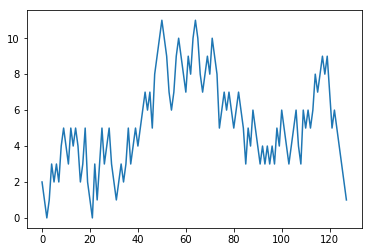

In [19]:
notes = scale.generate(4, 6)

# Generate 16th notes
n_notes = int(n_measures * 16)

p = [0.0005, 0.01, 0.1, 0.3, 0.0, 0.3, 0.1, 0.01, 0.0005]
p = p / np.sum(p)

steps = np.random.choice([-4, -3, -2, -1, 0, 1, 2, 3, 4],
                         n_notes - 1, p=p)

from music_generator.basic.utils import elastic_bounded_random_walk
rw = elastic_bounded_random_walk(steps, np.random.randint(0, len(notes)), 0, len(notes))

plt.plot(rw)

We can turn the random walk into an array of notes by indexing

In [20]:
np.array(notes)[rw.astype(int)]

array([F#4, E4, D4, E4, G4, F#4, G4, F#4, A4, B4, A4, G4, B4, A4, B4, A4,
       F#4, G4, B4, F#4, E4, D4, G4, E4, G4, B4, G4, A4, B4, G4, F#4, E4,
       F#4, G4, F#4, G4, B4, G4, A4, B4, A4, B4, C#5, D5, C#5, D5, B4, E5,
       F#5, G5, A5, G5, F#5, D5, C#5, D5, F#5, G5, F#5, E5, D5, F#5, E5,
       G5, A5, G5, E5, D5, E5, F#5, E5, G5, F#5, E5, B4, C#5, D5, C#5, D5,
       C#5, B4, C#5, D5, C#5, B4, G4, B4, A4, C#5, B4, A4, G4, A4, G4, A4,
       G4, A4, G4, B4, A4, C#5, B4, A4, G4, A4, B4, C#5, A4, G4, C#5, B4,
       C#5, B4, C#5, E5, D5, E5, F#5, E5, F#5, D5, B4, C#5, B4, A4, G4,
       F#4, E4], dtype=object)

Finally we can feed this to a synthesizer and generate some music

In [21]:
lead_measure = Measure(tempo, signature)
for i_note, note in enumerate(np.array(notes)[rw.astype(int)]):
    lead_measure.add_note(note, i_note/4, 1/4)

lead_trk = Track([lead_measure])

lead_instrument = make_lead_instrument(sampling_info)
lead_audio = lead_instrument.generate_track(lead_trk)

Mix it together with the chords

In [22]:
mix = chord_audio.copy()
mix = mix_at(0.5*mix, lead_audio, 0)

In [23]:
Audio(mix, rate=sr)